# Contents
1. Introduction <br>
    1.1. Import Libraries<br>
    1.2. Gaussian Distribution: Visual vs Statistical Tests Discussion <br>
    
    
2. Gathering and Cleaning Data <br> 
    2.1. Check Data <br>
    2.2. Data Cleaning <br>
    
    
3. Normalizing and Categorizing Data <br>
    3.1. Average Daily Range <br>
    3.2. Average Daily Range Distribution <br>
    3.3. Normalizing Distribution <br>
    3.4. Category Boundaries: Z-score vs Visual Interperatation Discussion <br>
    3.5. Average Daily Range: Category Boundaries  <br>
    3.6. Price Change and Sentiment Change  <br>
    3.7. Price and Sentiment Change Distributions <br>
    3.8. Confirming Normality via Z-score Percentiles <br>
    
    
4. Parametric vs Non-Parametric Correlation (Pearson, Spearman, Kendall-Tau) <br>
    4.1. Pearson's Assumptions <br>


5. Statistical Testing  <br>
    5.1. Correlation: Sentiment and Price Change <br>
    5.2. Correlation: Sentiment and Next Day Price Change <br>
    
    
6. Conclusion  <br>
    6.1. Limitations <br>
    6.2. Further Investigation <br>
    
    
7. Sources <br>

# 1. Introduction

Welcome to our retail sentiment kernel! We will be gathering financial data from Yahoo Finances and retail sentiment data from IG brokerage to investigate whether retail sentiment can serve as a lagging/leading indicator for price change in the currency pair Australian Dollar vs Japanese Yen (AUDJPY). 

## 1.1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls 
from datetime import datetime
import seaborn as sns
from pandas.tseries.offsets import Week
from scipy import stats
import scipy.stats
from scipy.stats import chi2_contingency
from scipy.stats import levene 
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

C:\Users\waqas\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1



## 1.2. Gaussian Distribution: Visual vs Statistical Tests Discussion

Throughout this notebook we will be applying statistical tests that presume the data is gaussian/normally distributed. In order to ensure the integrity of these tests, we verify various datasets are normalized throughout.  

Generally speaking, we have two ways of checking for normality - via statistical or visual tests. Throughout this notebook we 
will be using the latter; specifically histogram's and Q-Q plots. This is because statistical tests are too sensitive to the
large sample sizes (N) used in this work (Ghasemi & Zahediasl, 2012).

For statistical tests, as N increases, the degree of randomness impacting the sample will also increase, thus more deviation 
from a perfectly normalized distribrution. This effect in large sample sizes typically results in statistical tests being 
overly sensitive, thus rejecting normality in instances where normality, in practical terms, could otherwise be accepted 
(Ghasemi & Zahediasl, 2012). <br> 

Throughout our visual interperetations we will be discussing normality, kurtosis and skewedness in reference to histograms and QQ plot's. We will be discussing these more in-depth at the relevant stages but the images and links below serve as a good introduction to the topics;

https://www.simplypsychology.org/kurtosis.html <br> 
https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0 <br> 
https://www.learnbyexample.org/r-quantile-quantile-qq-plot-base-graph/ <br> 

<!-- <table><tr>
<td> <img src="Kurtosis.jpg" style="width: 400px; height:200px"> <td>
<td> <img src="Skew.jpg" style="width: 400px; height:200px"> <td> -->

<!-- <img src="QQ.jpg" style="width: 400px; height:400px"> -->

# 2. Gathering and Cleaning Data 

We get price data from using a web-scraper on Yahoo Financials. The sentiment data was collected via an Excel-add on. The two sets were merged in Excel before beginning. 

## 2.1. Check Data 

In [3]:
df=pd.read_csv('AUDJPY.csv', encoding='latin1')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,CloseLong,CloseShort,OpenLong,OpenShort,HighLong,HighShort,LowLong,LowShort
849,20/10/2022,93.834000,95.129997,93.379997,93.834000,93.834000,0.0,39,61,38,62,40,67,33,60
850,21/10/2022,94.223000,95.723000,93.127998,94.223000,94.223000,0.0,35,65,39,61,45,67,33,55
851,23/10/2022,NaN,NaN,NaN,NaN,NaN,NaN,36,64,35,65,36,65,35,64
852,24/10/2022,94.180000,94.797997,93.595001,94.180000,94.180000,0.0,36,64,34,66,37,67,33,63
853,25/10/2022,94.234001,94.652000,93.876999,94.234001,94.234001,0.0,34,66,37,63,38,67,33,62


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        854 non-null    object 
 1   Open        712 non-null    float64
 2   High        712 non-null    float64
 3   Low         712 non-null    float64
 4   Close       712 non-null    float64
 5   Adj Close   712 non-null    float64
 6   Volume      712 non-null    float64
 7   CloseLong   854 non-null    int64  
 8   CloseShort  854 non-null    int64  
 9   OpenLong    854 non-null    int64  
 10  OpenShort   854 non-null    int64  
 11  HighLong    854 non-null    int64  
 12  HighShort   854 non-null    int64  
 13  LowLong     854 non-null    int64  
 14  LowShort    854 non-null    int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 100.2+ KB


## 2.2. Data Cleaning 

Alot of the cleaning was done in Excel beforehand but a few things still remain. We need to remove unneeded columns as well as remove rows which coincide with either a sunday or a bank holiday (which can be detected via the NaN values in price data). 

In [5]:
df=df.drop(['CloseLong', 'CloseShort', 'OpenShort', 'HighLong', 'HighShort', 'LowLong', 'LowShort', 'Volume', 'Adj Close'], axis=1)
df.rename({'OpenLong':'Sentiment_Buys'}, axis=1, inplace=True)
df = df.dropna().reset_index(drop=True)
df.tail()

,Date,Open,High,Low,Close,Sentiment_Buys
707,19/10/2022,94.247002,94.385002,93.900002,94.247002,38
708,20/10/2022,93.834000,95.129997,93.379997,93.834000,38
709,21/10/2022,94.223000,95.723000,93.127998,94.223000,39
710,24/10/2022,94.180000,94.797997,93.595001,94.180000,34
711,25/10/2022,94.234001,94.652000,93.876999,94.234001,37


Our data is cleaned up! 

# 3. Normalizing and Categorizing Data

## 3.1. Average Daily Range

<img src="adr.PNG" />

Firstly we evaluate how much the market has moved on a given day. The standard procedure for this is the average daily range (formula shown above).

Problems arise when calculating this figure over too broad a range (looking too far back) since factors which influence market dynamics cause recency and situational bias' and these bias' need to be compensated for. For the sake of simplicity, we use a shorter time-frame to compensate. However, considerations such as seasonality, month, day, economic calender events etc. all serve as opportunities for deeper exploration. 

Moreover, a linear or exponential weighted average can be incorporated into the formula above to provide a heavier weighting toward more recent data points. 

In [6]:
#Rolling daily average over the last 20 days to evaluate daily price. 
DailyRangePercent = df.apply(lambda x: 100 * (x["High"] / x["Low"] - 1), axis=1)
df["AverageDailyRange"] = DailyRangePercent.rolling(window=20).mean()
df.drop(df.head(19).index,inplace=True)
df=df.reset_index(drop=True)
DailyRangePercent

0      0.554452
1      1.576147
2      1.059214
3      0.520382
4      1.317086
         ...   
707    0.516507
708    1.874063
709    2.786490
710    1.285321
711    0.825549
Length: 712, dtype: float64

## 3.2. Average Daily Range Distributions

<AxesSubplot:xlabel='AverageDailyRange', ylabel='Count'>

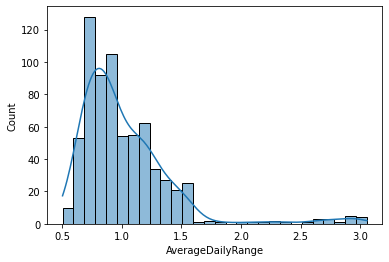

In [7]:
#Plot our data to explore the distribution of daily ranges. 
sns.histplot(data=df, 
             x='AverageDailyRange',
             kde=True
             )

Importantly, we observe a common phenomonen observed in the financial markets here - right skewed data. 

## 3.3. Normalizing Distribrution

### Outlier Removal
Incorporating, focusing or removing/clipping outliers are all viable approaches dependant on your strategy/objective. We will opt to remove our outliers since we desire a more 'normal', normal distribrution. This will be useful when we visually interpret our histograms for category boundaries later on. 

<AxesSubplot:xlabel='AverageDailyRange', ylabel='Count'>

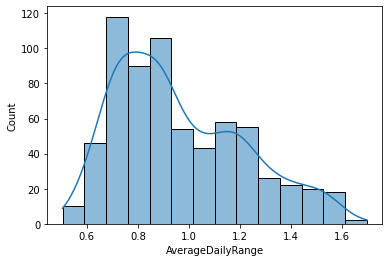

In [8]:
#Remove outliers.
dfnorm=df.loc[df['AverageDailyRange'] <= 1.7].reset_index(drop=True)
#Graph after positive outlier removal. 
sns.histplot(data=dfnorm, 
             x='AverageDailyRange',
             kde=True
             )

### Log Transformations 

A wide array of different transformations are available when normalizing data (square-root, natural log, inverse function etc.). Which is chosen is dependent on the direction and magnitude of the skew. <br> 

Our data contains a moderate/heavy right skew and a log transformation is the normal recommendation in such a scenario (West, 2021). 

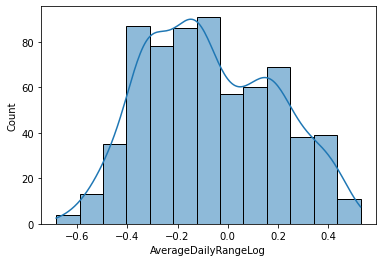

In [9]:
#log scaling to further normalize. 
df["AverageDailyRangeLog"] = np.log(df['AverageDailyRange'])
dfnorm["AverageDailyRangeLog"] = np.log(dfnorm['AverageDailyRange'])
sns.histplot(data=dfnorm, 
             x='AverageDailyRangeLog',
             kde=True
             )
df=df.drop(['AverageDailyRange'], axis=1)

Visually our distribrution is clearly much more normalized.

## 3.4. Category Boundaries: Z-score vs Visual Interperatation Discussion

Throughout this notebook we interchange between using z-score's (the statistically normalized procedure) vs. visual interperatation to define our category boundaries. Why?

In an academic since, interchanging is far from convention - but this is not an academic endeavour. This notebook is designed to explore whether edges within the financial market exist and in order to find such edges, we believe relying on human subjectivity (visual interperatation) is not only viable - but imperative. 

Looking at the graph above, we can readily identify a sharp falloff in frequency at -0.4 and ~0.25. Having noted this, it makes sense to use these values as cut-offs for our categories.

Later in this notebook, we define categories using z-score in instances where our dataset presents a graph with an extremely uniform normal distribrution and thus don't require (nor permit) visual interpretation.

## 3.5. Average Daily Range: Category Boundaries 

Define categories for the daily range; Tight, Average and Wide Range. The boundaries for these categories are based on
visual interpretation of the graph presented above. 

In [10]:
#Defining functions for daily range category boundaries. 
def TR(row):
    if row['AverageDailyRangeLog'] <= -0.4:
        return 'Yes'
    else:
        return 'No'
def AR(row):
    if -0.4 <= row['AverageDailyRangeLog'] <= .25:
        return 'Yes'
    else:
        return 'No'
def WR(row):
    if row['AverageDailyRangeLog'] > .25:
        return 'Yes'
    else:
        return 'No'

df['TightRange']=df.apply(TR, axis=1)
df['AverageRange']=df.apply(AR, axis=1)
df['WideRange']=df.apply(WR, axis=1)
df.head()

,Date,Open,High,Low,Close,Sentiment_Buys,AverageDailyRangeLog,TightRange,AverageRange,WideRange
0,28/02/2020,72.153999,72.164001,69.426003,72.153000,69,0.015484,No,Yes,No
1,02/03/2020,70.197998,71.190002,69.853996,70.168999,78,0.080206,No,Yes,No
2,03/03/2020,70.975998,71.456001,70.309998,71.019997,77,0.082685,No,Yes,No
3,04/03/2020,70.501999,71.290001,70.501999,70.461998,72,0.085373,No,Yes,No
4,05/03/2020,71.320000,71.321999,70.278999,71.350998,72,0.128665,No,Yes,No


## 3.6. Price Change and Sentiment Change 

Create columns which calculate price and sentiment change. 

In [11]:
df['Open_pct_Change']=df['Open'].pct_change()*100
df['Sentiment_Buys_pct_Change']=df['Sentiment_Buys'].pct_change()*100
df['Open_pct_Change'] = df['Open_pct_Change'].shift(-1)
df['Sentiment_Buys_pct_Change'] = df['Sentiment_Buys_pct_Change'].shift(-1)
df = df.dropna().reset_index(drop=True)
normalize=df[['Sentiment_Buys_pct_Change','Open_pct_Change']].copy()
df.head()

,Date,Open,High,Low,Close,Sentiment_Buys,AverageDailyRangeLog,TightRange,AverageRange,WideRange,Open_pct_Change,Sentiment_Buys_pct_Change
0,28/02/2020,72.153999,72.164001,69.426003,72.153000,69,0.015484,No,Yes,No,-2.710870,13.043478
1,02/03/2020,70.197998,71.190002,69.853996,70.168999,78,0.080206,No,Yes,No,1.108294,-1.282051
2,03/03/2020,70.975998,71.456001,70.309998,71.019997,77,0.082685,No,Yes,No,-0.667830,-6.493506
3,04/03/2020,70.501999,71.290001,70.501999,70.461998,72,0.085373,No,Yes,No,1.160252,0.000000
4,05/03/2020,71.320000,71.321999,70.278999,71.350998,72,0.128665,No,Yes,No,-1.397928,-1.388889


## 3.7. Price and Sentiment Change Distributions

count    692.000000
mean       0.581151
std       11.833260
min      -37.500000
25%       -6.808884
50%        0.000000
75%        7.142857
max       51.724138
Name: Sentiment_Buys_pct_Change, dtype: float64


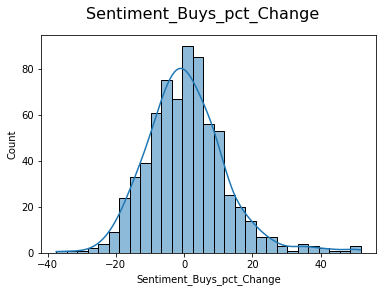

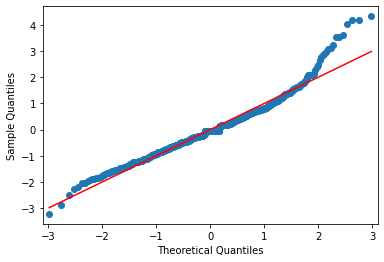

count    692.000000
mean       0.042260
std        0.858365
min       -7.588596
25%       -0.376981
50%        0.044494
75%        0.448240
max        8.638917
Name: Open_pct_Change, dtype: float64


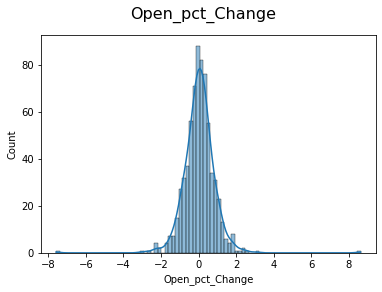

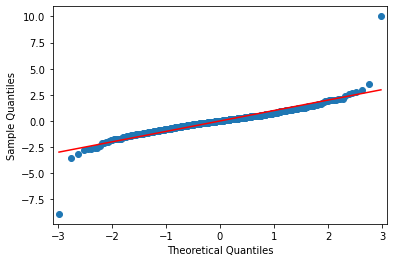

In [12]:
def report(a):
    plt.suptitle(a, fontsize=16)
    sns.histplot(data=normalize, 
             x=a,
             kde=True
             )
    sm.qqplot(normalize[a], line='s', fit=True)
    print(normalize[a].describe())
    plt.show()

for feature in normalize.columns:
    report(feature)

Our sentiment data shows a relatively normal distribrution with some fat tails with a clear right skew. As mentioned before, the skew is a common phemononen in financial markets. To normalize, we will apply a log transformation. 

Comparatively our price data is highly leptokurtic (alot of our values are centered towards the mean and within the tails). A reason for this are the clear outliers easily visible in the Q-Q plot. To produce a more mesokurtic shape, we will remove 
outliers. We will also be applying a log transformation again in order to reduce the right-skew. 

In [13]:
#Log transforming our open and sentiment columns. Also some dataframe cleanup. 
df['Log_Sentiment_Buys_pct_change']= np.log(1+df['Sentiment_Buys'].pct_change())*100
df['Log_Open_pct_change']= np.log(1+df['Open'].pct_change())*100
df = df.dropna().reset_index(drop=True)
normalize=df[['Log_Sentiment_Buys_pct_change', 'Log_Open_pct_change']].copy()
df=df.drop(['Sentiment_Buys_pct_Change','Open_pct_Change', 'Open', 'High', 'Low', 'Close', 'Sentiment_Buys', 'AverageDailyRangeLog'], axis=1)

We will be removing outliers in our price change data using z-score. Normal convention is to define outliers as data with
a z-score of +-3 (Rousseeuw & Hubert, 2011). However, much like before, we will utilize visual interperatation over statistical
convention. Looking at the Q-Q plot above for price change, outliers are notably visible at ~2.7 and will thus serve as our cutoff point. 

In [14]:
#Function for calculating z-score for outlier removal.
def zscore(s):
    return (s - np.mean(s)) / np.std(s)

In [15]:
#Outlier removal using z-score a cut-off of 2.7.
outliers=df[['Log_Open_pct_change']].copy()
outlierList=outliers[zscore(outliers['Log_Open_pct_change']).abs().gt(2.7)].index.tolist() 
df=df.drop(outlierList).reset_index(drop=True)
normalize=df[['Log_Sentiment_Buys_pct_change', 'Log_Open_pct_change']].copy()

count    682.000000
mean      -0.167628
std       11.545032
min      -47.000363
25%       -7.145896
50%        0.000000
75%        6.669137
max       41.689380
Name: Log_Sentiment_Buys_pct_change, dtype: float64


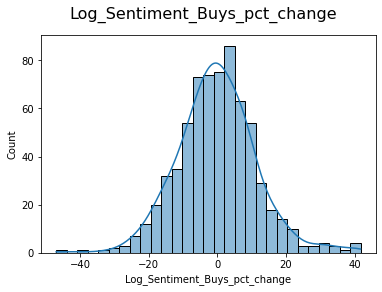

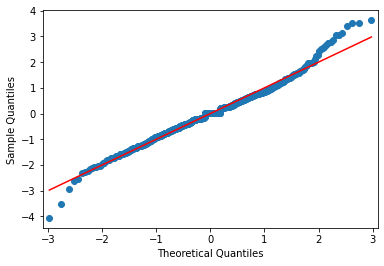

count    682.000000
mean       0.042204
std        0.693508
min       -2.252028
25%       -0.374452
50%        0.044484
75%        0.445424
max        2.321665
Name: Log_Open_pct_change, dtype: float64


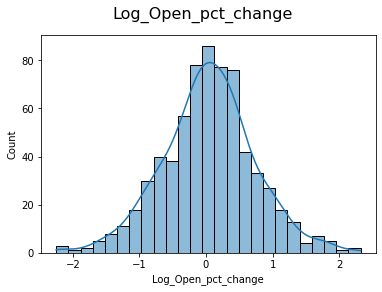

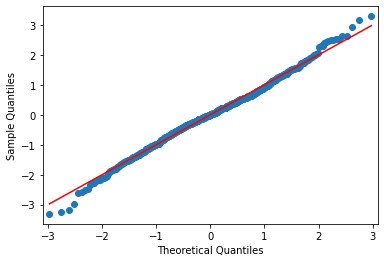

In [16]:
#Explore the distribution of sentiment and price change after log transformations and outlier removal. 
def report(a):
    plt.suptitle(a, fontsize=16)
    sns.histplot(data=normalize, 
             x=a,
             kde=True
             )
    sm.qqplot(normalize[a], line='s', fit=True)
    print(normalize[a].describe())
    plt.show()

for feature in normalize.columns:
    report(feature)

After log transformation, our sentiment data has less right skew with thinner tails.

After log transformation and outlier removal, our price change data has shifted to a significantly more mesokurtic distribrution.

In [17]:
#Removing outliers.
df=df.drop(outlierList).reset_index(drop=True)

## 3.8. Confirming Normality via Z-score Percentiles 


These data sets are seemingly normalized but we will confirm by examining the z-score distributions. 

First we will categorize our price and sentiment change based on z-score. A z-score of 1 represents a standard deviation of 1 above the mean, 2 represents a standard deviation of 2 and so forth.  

Assuming normality we would expect a percentile distribution of 34.5, 13.5 and 2% for z-scores of 1 2, 3 respectively (Glen, n.d.). 

In [18]:
#New columns which give z-scores for sentiment and price change. 
df['zscoresentiment'] = zscore(df['Log_Sentiment_Buys_pct_change'])
df['zscoreopen'] = zscore(df['Log_Open_pct_change'])

#Defining functions which categorize sentiment and price change based on z-score. 
def zscoresentiment(row):
    if row['zscoresentiment'] <= -2:
        return 'Major Sell (S)'
    if row['zscoresentiment'] <= -1:
        return 'Moderate Sell (S)'
    if row['zscoresentiment'] <= -0:
        return 'Minor Sell (S)'
    if row['zscoresentiment'] <= 1:
        return 'Minor Buy (S)'
    if row['zscoresentiment'] <= 2:
        return 'Moderate Buy (S)'
    else:
        return 'Major Buy (S)'
    
def zscoreprice(row):
    if row['zscoreopen'] <= -2:
        return 'Major Sell (P)'
    if row['zscoreopen'] <= -1:
        return 'Moderate Sell (P)'
    if row['zscoreopen'] <= -0:
        return 'Minor Sell (P)'
    if row['zscoreopen'] <= 1:
        return 'Minor Buy (P)'
    if row['zscoreopen'] <= 2:
        return 'Moderate Buy (P)'
    else:
        return 'Major Buy (P)'

Minor Buy (S)        41.456166
Minor Sell (S)       31.500743
Moderate Sell (S)    12.184250
Moderate Buy (S)     10.104012
Major Buy (S)         2.674591
Major Sell (S)        2.080238
Name: Sentiment, dtype: float64

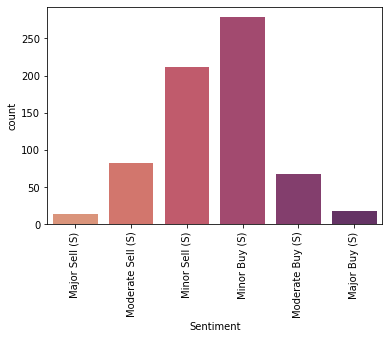

In [19]:
df['Sentiment']=df.apply(zscoresentiment, axis=1)
order = ["Major Sell (S)", "Moderate Sell (S)", "Minor Sell (S)", "Minor Buy (S)", "Moderate Buy (S)", "Major Buy (S)"]
plt.xticks(rotation=90)
sns.countplot(x = "Sentiment", 
              data = df, 
              order = order,
              palette='flare')
df['Sentiment'].value_counts(normalize=True) * 100 

Minor Buy (P)        35.958395
Minor Sell (P)       34.175334
Moderate Sell (P)    13.224368
Moderate Buy (P)     11.441308
Major Buy (P)         2.674591
Major Sell (P)        2.526003
Name: Price_Change, dtype: float64

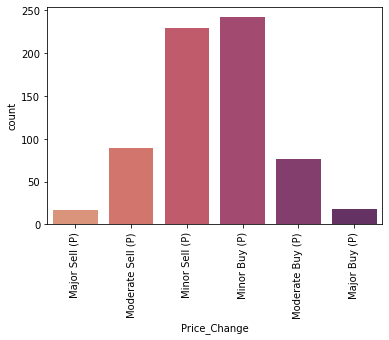

In [20]:
df['Price_Change']=df.apply(zscoreprice, axis=1)
plt.xticks(rotation=90)
order1 = ["Major Sell (P)", "Moderate Sell (P)", "Minor Sell (P)", "Minor Buy (P)", "Moderate Buy (P)", "Major Buy (P)"]
sns.countplot(x = "Price_Change", 
              data = df, 
              order = order1,
              palette='flare')
df['Price_Change'].value_counts(normalize=True) * 100 

Visual inspection and percentile breakdowns for each category indicate our data is sufficiently normalized!

# 4. Parametric vs Non-Parametric Correlation (Pearson, Spearman, Kendall-Tau)

We must choose a test for checking the correlation between price and sentiment change. The typical choices are between Pearson's, Spearman's and Kendall-Tau's. 

The first choice to be made when picking between these is choosing between parametric (Pearson's) vs non-parametric (Spearman's/Kendall-Tau's). If opting for non-parametric, our second choice becomes picking between Spearman's vs Kendall-Tau's. 

Pearson's is our first recommendation. Parametric tests are more powerful than their non-parametric counterparts. Whilst Pearson's considers the mean and deviation from the mean, their non-parametric counterparts only use ordinal information (Mircioiu & Atkinson, 2017). However, Pearson's requires certain assumptions to be met before it can be used (listed below).


## 4.1. Pearson's Assumptions (Schober et al, 2018):
1. Each observation should have a pair of values (True).
2. Each variable should be continuous (True).
3. Absence of outliers (True).
4. Both variables follow normal distributions (True).
5. Linearity and homoscedasticity (Unproven).


We will test for linearity via a simple scatter graph. 

If our data fails to meet these requirements, we then opt to use Kendall-Tau over Spearman's as our preference in non-parametric correlation testing. Whilst both are similar in function, and whilst Spearman typically serves as the default choice in non-parametric correlation testing, we will instead opt for Kendall-Tau since it will provide more reliable P-values considering the smaller sample sizes we will be working with (Bonett & Wright, 2000). <br> 


<AxesSubplot:xlabel='Log_Sentiment_Buys_pct_change', ylabel='Log_Open_pct_change'>

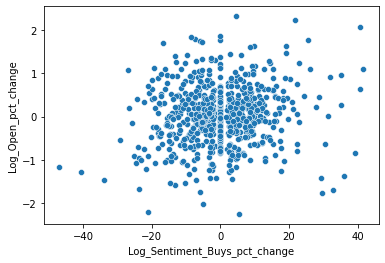

In [21]:
sns.scatterplot(data=df, 
             x="Log_Sentiment_Buys_pct_change",
             y='Log_Open_pct_change'
             )

Our scatter graph is giving no clear indication of linearity meaning we'll be using our non-parametric choice of test - Kendall-Tau (non-parametric correlations check for a monotonic relationship i.e. variables moving in the same relative direction but not necessarily at a constant rate). 

# 5. Statistical Testing 

## 5.1. Correlation: Sentiment and Price Change

In [22]:
s,pp=scipy.stats.kendalltau(df.Log_Sentiment_Buys_pct_change, df.Log_Open_pct_change)
print('Spearman Correlation S Value: ' + str(s))
print('Spearman Correlation P Value: ' + str(pp))

Spearman Correlation S Value: 0.07815985242365714
Spearman Correlation P Value: 0.0025789402511430114


We have an extremely weak/negligible correlation between sentiment and price change. Next we investigate the correlation within different sentiment groups. 

### Correlation: Different Sentiment Groups and Price Change 

In [23]:
df1=df.loc[(df['Sentiment'] == 'Minor Buy (S)') | (df['Sentiment'] == 'Minor Sell (S)')]
df2=df.loc[(df['Sentiment'] == 'Moderate Buy (S)') | (df['Sentiment'] == 'Moderate Sell (S)')]
df3=df.loc[(df['Sentiment'] == 'Major Buy (S)') | (df['Sentiment'] == 'Major Sell (S)')]

s,pp=scipy.stats.kendalltau(df1.Log_Sentiment_Buys_pct_change, df1.Log_Open_pct_change)
print('Minor: Kendall-Tau Correlation S Value: ' + str(s))
print('Minor: Kendall-Tau Correlation P Value: ' + str(pp))
print('Minor: Sample Size: ' + str(df1.shape[0]))
print('------------------------------------------------------------')
s1,pp1=scipy.stats.kendalltau(df2.Log_Sentiment_Buys_pct_change, df2.Log_Open_pct_change)
print('Moderate: Kendall-Tau Correlation S Value: ' + str(s1))
print('Moderate: Kendall-Tau Correlation P Value: ' + str(pp1))
print('Moderate: Sample Size: ' + str(df2.shape[0]))
print('------------------------------------------------------------')
s2,pp2=scipy.stats.kendalltau(df3.Log_Sentiment_Buys_pct_change, df3.Log_Open_pct_change)
print('Major: Kendall-Tau Correlation S Value: ' + str(s2))
print('Major: Kendall-Tau Correlation P Value: ' + str(pp2))
print('Major: Sample Size: ' + str(df3.shape[0]))

Minor: Kendall-Tau Correlation S Value: 0.028728602943124616
Minor: Kendall-Tau Correlation P Value: 0.34684900267128393
Minor: Sample Size: 491
------------------------------------------------------------
Moderate: Kendall-Tau Correlation S Value: 0.0952263721398204
Moderate: Kendall-Tau Correlation P Value: 0.08521416994881825
Moderate: Sample Size: 150
------------------------------------------------------------
Major: Kendall-Tau Correlation S Value: 0.21010143883614574
Major: Kendall-Tau Correlation P Value: 0.09161204208606656
Major: Sample Size: 32


Our results show when sentiment has shifted a minor amount, the correlation between sentiment and price change breaks down.
However, the further sentiment shifts from the mean, the stronger the correlation gets (increased S Value). 

It should be noted that P > .05, indicating we should accept the null hypothesis, however we challenge this based on various 
reasons discussed extensively in the limitations section found at the end of this notebook. Within this notebook we work under
the assumption of a lower P-value threshhold (0.1).

Next we test if sentiment works as a leading indicator by running correlation tests between daily sentiment change and the subsequent day's price change. 

## 5.2. Correlation: Sentiment and Next Day Price Change

First we need to make a new column consisting of the subsequent day's price change. 

In [24]:
df['Next_Days_Log_Open_pct_change'] = df['Log_Open_pct_change'].shift(-1)
df['Next_Days_Price_Change'] = df['Price_Change'].shift(-1)
df = df.dropna().reset_index(drop=True)

In [25]:
s,pp=scipy.stats.kendalltau(df.Log_Sentiment_Buys_pct_change, df.Next_Days_Log_Open_pct_change)
print('Kendall-Tau Correlation S Value: ' + str(s))
print('Kendall-Tau Correlation P Value: ' + str(pp))

Kendall-Tau Correlation S Value: 0.03554727942115246
Kendall-Tau Correlation P Value: 0.17078298104332001


No statistically significant correlation found. Next we investigate our sentiment sub-groups. 

### Correlation: Different Sentiment Groups and Price Change 

In [26]:
df1_Next_Day=df.loc[(df['Sentiment'] == 'Minor Buy (S)') | (df['Sentiment'] == 'Minor Sell (S)')]
df2_Next_Day=df.loc[(df['Sentiment'] == 'Moderate Buy (S)') | (df['Sentiment'] == 'Moderate Sell (S)')]
df3_Next_Day=df.loc[(df['Sentiment'] == 'Major Buy (S)') | (df['Sentiment'] == 'Major Sell (S)')]

s,pp=scipy.stats.kendalltau(df1_Next_Day.Log_Sentiment_Buys_pct_change, df1_Next_Day.Next_Days_Log_Open_pct_change)
print('Minor Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s))
print('Minor Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp))
print('Minor Sentiment Change: Sample Size: ' + str(df1_Next_Day.shape[0]))
print('------------------------------------------------------------')
s1,pp1=scipy.stats.kendalltau(df2_Next_Day.Log_Sentiment_Buys_pct_change, df2_Next_Day.Next_Days_Log_Open_pct_change)
print('Moderate Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s1))
print('Moderate Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp1))
print('Moderate Sentiment Change: Sample Size: ' + str(df2_Next_Day.shape[0]))
print('------------------------------------------------------------')
s2,pp2=scipy.stats.kendalltau(df3_Next_Day.Log_Sentiment_Buys_pct_change, df3_Next_Day.Next_Days_Log_Open_pct_change)
print('Major Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s2))
print('Major Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp2))
print('Major Sentiment Change: Sample Size: ' + str(df3_Next_Day.shape[0]))

Minor Sentiment Change: Kendall-Tau Correlation S Value: 0.008818190349296826
Minor Sentiment Change: Kendall-Tau Correlation P Value: 0.77277128551866
Minor Sentiment Change: Sample Size: 491
------------------------------------------------------------
Moderate Sentiment Change: Kendall-Tau Correlation S Value: 0.027797095060434134
Moderate Sentiment Change: Kendall-Tau Correlation P Value: 0.616580070042944
Moderate Sentiment Change: Sample Size: 149
------------------------------------------------------------
Major Sentiment Change: Kendall-Tau Correlation S Value: 0.15757607912710928
Major Sentiment Change: Kendall-Tau Correlation P Value: 0.2057938705052046
Major Sentiment Change: Sample Size: 32


No statistically significant correlations found. Next we investigate our price-change sub-groups. 

### Correlation: Different Sentiment Groups and Price Change: Tight Ranges

In [27]:
dfRange=df.loc[(df['TightRange'] == 'Yes')]

df1TR=dfRange.loc[(dfRange['Sentiment'] == 'Minor Buy (S)') | (dfRange['Sentiment'] == 'Minor Sell (S)')]
df2TR=dfRange.loc[(dfRange['Sentiment'] == 'Moderate Buy (S)') | (dfRange['Sentiment'] == 'Moderate Sell (S)')]
df3TR=dfRange.loc[(dfRange['Sentiment'] == 'Major Buy (S)') | (dfRange['Sentiment'] == 'Major Sell (S)')]

s,pp=scipy.stats.kendalltau(df1TR.Log_Sentiment_Buys_pct_change, df1TR.Next_Days_Log_Open_pct_change)
print('Minor Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s))
print('Minor Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp))
print('Minor Sentiment Change: Sample Size: ' + str(df1TR.shape[0]))
print('------------------------------------------------------------')
s1,pp1=scipy.stats.kendalltau(df2TR.Log_Sentiment_Buys_pct_change, df2TR.Next_Days_Log_Open_pct_change)
print('Moderate Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s1))
print('Moderate Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp1))
print('Moderate Sentiment Change: Sample Size: ' + str(df2TR.shape[0]))
print('------------------------------------------------------------')
s2,pp2=scipy.stats.kendalltau(df3TR.Log_Sentiment_Buys_pct_change, df3TR.Next_Days_Log_Open_pct_change)
print('Major Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s2))
print('Major Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp2))
print('Major Sentiment Change: Sample Size: ' + str(df3TR.shape[0]))

Minor Sentiment Change: Kendall-Tau Correlation S Value: 0.25781624382626805
Minor Sentiment Change: Kendall-Tau Correlation P Value: 0.028051404833946303
Minor Sentiment Change: Sample Size: 36
------------------------------------------------------------
Moderate Sentiment Change: Kendall-Tau Correlation S Value: 0.19138975058773822
Moderate Sentiment Change: Kendall-Tau Correlation P Value: 0.3217063432062476
Moderate Sentiment Change: Sample Size: 15
------------------------------------------------------------
Major Sentiment Change: Kendall-Tau Correlation S Value: 1.0
Major Sentiment Change: Kendall-Tau Correlation P Value: 1.0
Major Sentiment Change: Sample Size: 2


With Tight Daily Range, we don't have enough N for moderate and major sentiment changes for any meaningful testing. However with minor sentiment change, we find a meaningful correlation to the next day's price change (S=0.25, P=0.028, N=36).

### Correlation: Different Sentiment Groups and Price Change: Average Ranges

In [28]:
dfRange=df.loc[(df['AverageRange'] == 'Yes')]

df1AR=dfRange.loc[(dfRange['Sentiment'] == 'Minor Buy (S)') | (dfRange['Sentiment'] == 'Minor Sell (S)')]
df2AR=dfRange.loc[(dfRange['Sentiment'] == 'Moderate Buy (S)') | (dfRange['Sentiment'] == 'Moderate Sell (S)')]
df3AR=dfRange.loc[(dfRange['Sentiment'] == 'Major Buy (S)') | (dfRange['Sentiment'] == 'Major Sell (S)')]

s,pp=scipy.stats.kendalltau(df1AR.Log_Sentiment_Buys_pct_change, df1AR.Next_Days_Log_Open_pct_change)
print('Minor Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s))
print('Minor Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp))
print('Minor Sentiment Change: Sample Size: ' + str(df1AR.shape[0]))
print('------------------------------------------------------------')
s1,pp1=scipy.stats.kendalltau(df2AR.Log_Sentiment_Buys_pct_change, df2AR.Next_Days_Log_Open_pct_change)
print('Moderate Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s1))
print('Moderate Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp1))
print('Moderate Sentiment Change: Sample Size: ' + str(df2AR.shape[0]))
print('------------------------------------------------------------')
s2,pp2=scipy.stats.kendalltau(df3AR.Log_Sentiment_Buys_pct_change, df3AR.Next_Days_Log_Open_pct_change)
print('Major Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s2))
print('Major Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp2))
print('Major Sentiment Change: Sample Size: ' + str(df3AR.shape[0]))

Minor Sentiment Change: Kendall-Tau Correlation S Value: 0.006184276228293509
Minor Sentiment Change: Kendall-Tau Correlation P Value: 0.8574336958134906
Minor Sentiment Change: Sample Size: 387
------------------------------------------------------------
Moderate Sentiment Change: Kendall-Tau Correlation S Value: 0.04050452660282143
Moderate Sentiment Change: Kendall-Tau Correlation P Value: 0.5361059414663265
Moderate Sentiment Change: Sample Size: 108
------------------------------------------------------------
Major Sentiment Change: Kendall-Tau Correlation S Value: 0.3122529644268775
Major Sentiment Change: Kendall-Tau Correlation P Value: 0.038351323943696045
Major Sentiment Change: Sample Size: 23


With Average Daily Range, mild and moderate sentiment change is not correlative with next day price change (P=0.82 and 0.54 
respectively). However there is a moderate correlation with major sentiment change (S=0.31, P=0.38, N=23).

### Correlation: Different Sentiment Groups and Price Change: Wide Ranges

In [29]:
dfRange=df.loc[(df['WideRange'] == 'Yes')]

df1WR=dfRange.loc[(dfRange['Sentiment'] == 'Minor Buy (S)') | (dfRange['Sentiment'] == 'Minor Sell (S)')]
df2WR=dfRange.loc[(dfRange['Sentiment'] == 'Moderate Buy (S)') | (dfRange['Sentiment'] == 'Moderate Sell (S)')]
df3WR=dfRange.loc[(dfRange['Sentiment'] == 'Major Buy (S)') | (dfRange['Sentiment'] == 'Major Sell (S)')]

s,pp=scipy.stats.kendalltau(df1WR.Log_Sentiment_Buys_pct_change, df1WR.Next_Days_Log_Open_pct_change)
print('Minor Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s))
print('Minor Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp))
print('Minor Sentiment Change: Sample Size: ' + str(df1WR.shape[0]))
print('------------------------------------------------------------')
s1,pp1=scipy.stats.kendalltau(df2WR.Log_Sentiment_Buys_pct_change, df2WR.Next_Days_Log_Open_pct_change)
print('Moderate Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s1))
print('Moderate Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp1))
print('Moderate Sentiment Change: Sample Size: ' + str(df2WR.shape[0]))
print('------------------------------------------------------------')
s2,pp2=scipy.stats.kendalltau(df3WR.Log_Sentiment_Buys_pct_change, df3WR.Next_Days_Log_Open_pct_change)
print('Major Sentiment Change: Kendall-Tau Correlation S Value: ' + str(s2))
print('Major Sentiment Change: Kendall-Tau Correlation P Value: ' + str(pp2))
print('Major Sentiment Change: Sample Size: ' + str(df3WR.shape[0]))

Minor Sentiment Change: Kendall-Tau Correlation S Value: -0.047221137454355744
Minor Sentiment Change: Kendall-Tau Correlation P Value: 0.5737791331833589
Minor Sentiment Change: Sample Size: 68
------------------------------------------------------------
Moderate Sentiment Change: Kendall-Tau Correlation S Value: -0.04012364789925056
Moderate Sentiment Change: Kendall-Tau Correlation P Value: 0.7743577578004968
Moderate Sentiment Change: Sample Size: 26
------------------------------------------------------------
Major Sentiment Change: Kendall-Tau Correlation S Value: -0.23809523809523814
Major Sentiment Change: Kendall-Tau Correlation P Value: 0.5619047619047619
Major Sentiment Change: Sample Size: 7


With Wide Daily Range, no statistically significant correlations are found. 

# 6. Conclusion

We found sentiment can serve as a weak lagging indicator of price change with it's correlative power increasing as sentiment change increases. We also found sentiment could potentially serve as a weak-moderate leading indicator for next day's price change in instances of a Tight Daily Range + Minor Sentiment Change and Average Daily Range + Major Sentiment Change however more evidence is required.


## 6.1. Limitations
### Small Sample Sizes: 

The correlations we found with Tight Daily Range + Minor Sentiment Change and Average Daily Range + Major Sentiment Change with
next day price change have N's of 36 and 23 respectively. The minimum sample size required in Kendall-Tau tests (for 90% confidence interval) is ~70 (Bonett & Wright, 2000). Thus further results are needed before conclusively accepting these correlations. Investigating if other currency pairs return similar results would also offer further confidence.


Due to retail sentiment data being a recent phenomenon, there simply aren't enough data points yet. 

### Lower P Threshhold for Sentiment and Price Change Correlation Test:

Generally speaking, a P-value of 0.05 is considered the cut-off between statistical significance/insignificance. However this threshhold is somewhat "arbitrary" and can be adjusted dependent on objective (Betensky, 2018). We believe our work qualifies for lowering the threshhold for the following reasons:

- This work isn't an academic endeavour. In an attempt to find edges in the financial markets, we believe lowering the P threshold is a neccessity since the domain is notoriously 'efficient' by nature (Boyle, 2022). 

-  As N decreases, P accuracy lessens (Bonett & Wright, 2000). When running our tests on all of our data (larger N), 
our P-value was <.05. It's only when lessening our sample sizes did we fail to hit this threshold. This means our higher P-value could potentially be attributed to small sample size contribruting to P-value inaccuracy.

- Our P-value for minor sentiment change is .34 however, our P-value for moderate and major sentiment change is <.1.
Meaning in relative terms, our P-values are clearly converging toward <0.05 as sentiment moves away from the mean. 

## 6.2. Further Investigation

Collecting more data (N) to satisfy minimum sample size requirement for Kendall-Tau correlation test. <br>
Investigating other markets for similar results. <br>
Adding further co-variables (momentum, seasonality, economic events etc.).<br>

## 7. Sources

Betensky, R (2018). The p-Value Requires Context, Not a Threshold. The American Statistician, (73), 115-117. <br>
Boyle, M (2022). Market Efficiency Explained: Differing Opinions and Examples. https://www.investopedia.com/terms/m/marketefficiency.asp <br>
Bonett, D. G., & Wright, T. A. (2000). Sample size requirements for estimating Pearson, Kendall and Spearman correlations. Psychometrika, 65(1), 23-28. <br>
Ghasemi, A., & Zahediasl, S. (2012). Normality Tests for Statistical Analysis: A Guide for Non-Statisticians. Int J Endocrinol Metab, 10(2), 486–489. <br>
Glen, S. (n.d). Z score to Percentile / Percentile to Z Score (Calculator). https://www.statisticshowto.com/probability-and-statistics/find-critical-values/percentile-z-score/. <br>
Mircioiu, C., Atkinson, J. (2017). A Comparison of Parametric and Non-Parametric Methods Applied to a Likert Scale, Pharmacy (Basel), 5(2), 26. <br>
Rousseeuw, P., Hubert, M. (2011). Robust statistics for outlier detection, Wiley Interdisciplinary Reviews, 1(1), 73-79. <br>
Schober, P.,  Boer, C.,  Schwarte, Lothar A. (2018). Correlation Coefficients: Appropriate Use and Interpretation, Anesthesia & Analgesia, 126(5), 1763-1768. <br>
West, R. (2021). Best practice in statistics: The use of log transformation, Annual Clinical Biochemistry, 59(3), 162–165. <br>